# Ajuste de gaussianas
Ejercicios de entrenamiento en análisi de espectros gamma 
autor: Fernando Cristancho (lfcristancho@unal.edu.co)

In [1]:
%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator,AutoLocator)
from pandas import DataFrame as df
from scipy.integrate import quad

import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams.update({'font.size': 20})

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import NullFormatter


def cm2inch(cm):
    return cm/2.54

def gaussBckgrnd(x,m,s,M,b0,b1):
    z = (m-x)/s
    gauss = M*np.exp(-0.5*z**2)
    fondo = b0 + b1 * (x - m)
    return gauss + fondo

def tandem(x,m1,s1,M1,m2,s2,M2,b0,b1):
    z1 = (m1-x)/s1
    gauss1 = M1*np.exp(-0.5*z1**2)
    z2 = (m2-x)/s2
    gauss2 = M2*np.exp(-0.5*z2**2)
    mm = (m1 + m2)/2
    fondo = b0 + b1 * (x - mm)
    return gauss1 + gauss2 + fondo

def recta(x,b0,b1,x0):
    return b0 + b1 * (x-x0)

def gauss(x,m,s,M):
    z = (m-x)/s
    return M*np.exp(-0.5*z**2)

# toma las salidas de curve_fit: parámetros= pot, matriz de covariaza = pcov
# La diagonal de la matriz de covarianza es la covarianza de cada parámetro. Su raíz cuadrada es la desviación estándar.
def statsGauss_tabla(popt,pcov):
    mu = popt[0] 
    stdv_mu = np.sqrt(pcov[0,0])
    
    s = popt[1]
    s = np.abs(s) # curve_fit puede producir s < 0, sin efecto adverso. 
    stdv_s = np.sqrt(pcov[1,1])
    
    M = popt[2]
    stdv_M = np.sqrt(pcov[2,2])
    
    b0 = popt[3]
    stdv_b0 = np.sqrt(pcov[3,3])
    
    b1 = popt[4]
    stdv_b1 = np.sqrt(pcov[4,4])
    
    I = np.sqrt(2*np.pi)*s*M
    stdv_I = I * np.sqrt((stdv_s/s)**2 + (stdv_M/M)**2) 

    print('   M(c/cnl)      mu(cnl)     sigma(cnl)   I(c) ')
    print('{0:4.2f}({1:2.2f}) &{2:4.1f}({3:2.1f}) &{4:3.1f}({5:2.1f}) &{6:5.0f}({7:3.0f})  \\\\'.format(M,stdv_M,mu,stdv_mu,s,stdv_s,I,stdv_I))
    

En adelante veremos el ajuste a la función
$
f(x)=r(x)+g(x) \\
r(x)=b_0+b_1(\mu-x)\\
g(x)=M\exp\left[ -\frac{1}{2}\left( \frac{\mu-x}{\sigma}\right)^2\right]
$
El primer espectro fue obtenido detectando rayos gamma con un detector NaI (3"x3")

In [2]:
#f0 = pd.read_csv('../in-out/22Na5min.csv')
f0= np.genfromtxt('./datos/NaI_22Na_600s.dat',dtype=int,usecols=(1),skip_header=1)
#f1 = pd.read_csv('../data/NaI_22Na_600s.csv',header=8)

In [6]:
#x0 = f0['Energia(canal)'].to_numpy()
x0 = np.arange(0,len(f0))
#x1 = np.arange(0,len(f1['cuentas']))
#x1 = f1['Energia(canal)'].to_numpy()
y0 = f0
#y1 = f1['cuentas']
#plt.xlabel('cuentas')
#print(y0[45])

4259


Primera gráfica: el espectro entero. Contiene tres picos correspondientes en orden creciente de energía a 511 keV, 1274 keV y el pico suma de las dos anteriores energías.

In [8]:
plt.figure(figsize=(cm2inch(30.0),cm2inch(16.0)))
plt.plot(x0,y0)#,drawstyle='steps-mid',linewidth=2,color=(0.8,0,0,1),label=r'$^{22}$Na')
#plt.plot(x1[0:1500],y1[0:1500],drawstyle='steps-mid',linewidth=2,color=(0,0,0.8,1),label='22Na 10 minutos')
#plt.legend()
#plt.yscale('log')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000124E771A790> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 850.394x453.543 with 1 Axes>

Ahora vamos a tomar solamente la parte del espectro que contiene el pico de más alta energía...

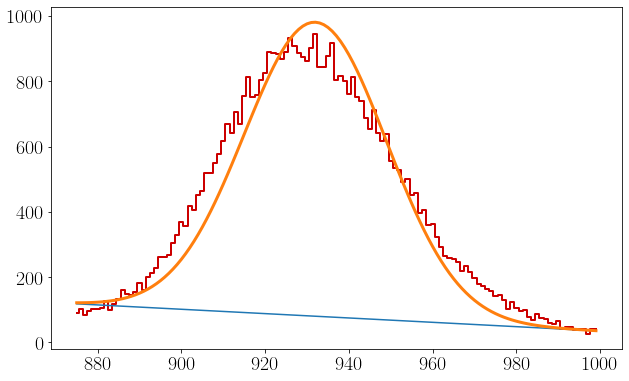

In [57]:
x=x0[875:1000]
y=y0[875:1000]
plt.figure(figsize=(cm2inch(26.0),cm2inch(16.0)))
plt.plot(x,y,drawstyle='steps-mid',linewidth=2,color=(0.8,0,0,1))
# siguientes líneas: inicialización de los parámetros de ajuste
mu = 932
s = 17
M = 901
b0 = 80
b1 = -80/120
rf = recta(x,b0,b1,mu)
plt.plot(x,rf)
gf = gaussBckgrnd(x,mu,s,M,b0,b1)
plt.plot(x,gf,lw=3); # Miramos qué tan buenos son los parámetros graficando con ellos (sin ajustar todavía)

In [58]:
# Evaluación de la pendiente de la línea  recta, b1:
(0-100)/(1000-875)

-0.8

"Empaquetamos" los parámetros iniciales en el arreglo 'p0' y pedimos el ajuste.

In [59]:
p0 = np.array([mu,s,M,b0,b1])
popt, pcov = curve_fit(gaussBckgrnd,x,y,p0,sigma=np.sqrt(y))

"Desempaquetamos" los parámetros resultantes para usarlos en la producción de la curva ajustada 'y_fit' 

   M(c/cnl)      mu(cnl)     sigma(cnl)   I(c) 
854.37(6.79) &930.0(0.2) &21.1(0.2) &45221(565)  \\


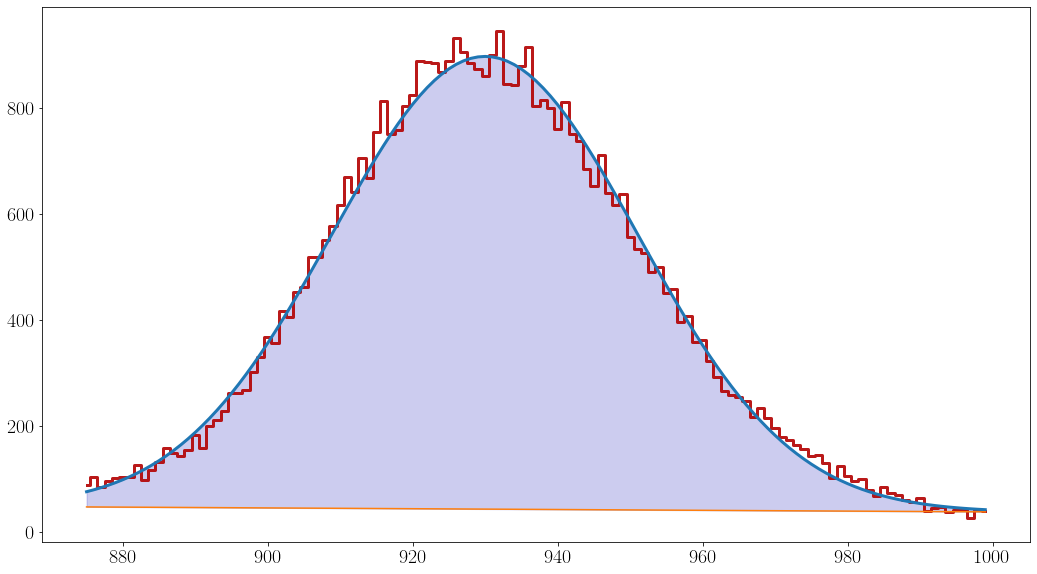

In [60]:
mu,s,M,b0,b1 = popt
y_fit = gaussBckgrnd(x,mu,s,M,b0,b1)
r_fit = recta(x,b0,b1,mu)
plt.figure(figsize=(cm2inch(45.0),cm2inch(25.0)))
plt.plot(x,y,drawstyle='steps-mid',linewidth=3,color=(0.7,0,0,0.9))
plt.plot(x,y_fit,lw=3)
plt.plot(x,r_fit)
plt.fill_between(x,r_fit,y_fit,color=(0,0,0.7,0.2));
statsGauss_tabla(popt,pcov) # La salida produce resultados listos para incluir y editar en latex. Pero falta depurar la notación de las incertidumbres...

A veces ajustamos picos para averiguar cuál es su integral. En muchas ocasiones "no tenemos la más peregrina idea" de cuánto podría resultar para la integral. El siguiente es un método que uso para evaluar si el software o yo estamos haciendo algo mal. Evalúo la integral de la gaussiana aproximándola a un triángulo:

área de un triángulo = base*altura/2 

base = 6*$\sigma$

altura  = $M$

$
I \approx (6\sigma) \times M / 2 = 3\sigma M
$

In [61]:
3*s*M

54121.66674705867

## Restando espectros 
'NaI_57Co_300s.csv' : datos de la detección de los rayos gamma emitidos por una fuente de $^{57}$Co durante 300 segundos (5 minutos).

In [62]:
f1 = pd.read_csv('../in-out/NaI_57Co_300s.csv',header=8)

In [63]:
x1 = f1['canal']
y1 = f1['cuentas']

In [64]:
print(len(x1))
print(len(y1))

1024
1024


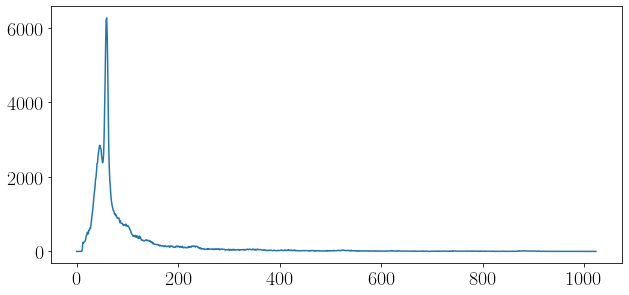

In [65]:
x = np.arange(0,len(x1))
plt.figure(figsize=(cm2inch(26.0),cm2inch(12.0)))
plt.plot(x,y1);

In [66]:
f2 = pd.read_csv('../in-out/NaI_Fondo_300s.csv',header=8) #: Fondo: detección sin fuente alguna en las cercanías del detector.

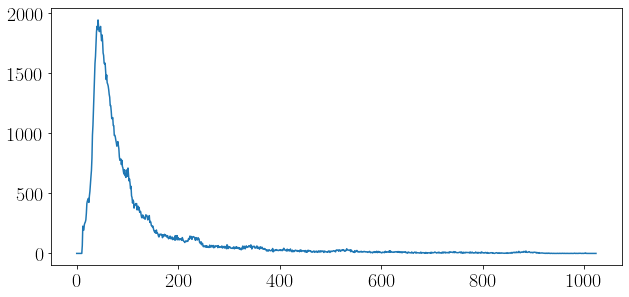

In [67]:
x2 = f2['canal']
y2 = f2['cuentas']
plt.figure(figsize=(cm2inch(26.0),cm2inch(12.0)))
plt.plot(x,y2);

Figura anterior: El "pico" entre los canales 0-180 es debido a toda la radiación proveniente esencialmente de los materiales radiactivos naturales y de la radiación cósmica. Esto no quiere decir que la radiación de fondo tenga bajas energías. En realidad algunas emisiones naturales son tan altas como de 2.6 MeV. El pico entre 0 y 180 keV se forma como acumulación de radiación originada en el efecto Compton de rayos gamma de alta y mediana (1 MeV) energía.

Hagamos zoom en la región de baja energía y examinemos simultánemaente los dos espectros visualizados más arriba...

In [68]:
bajo = 0
alto = 200

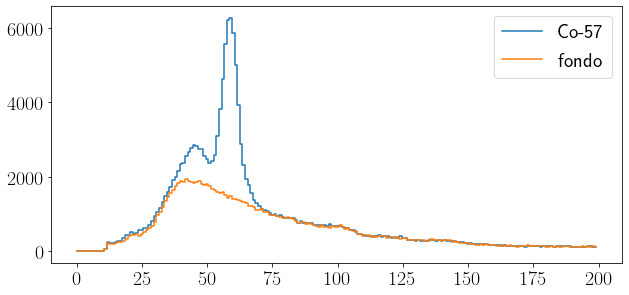

In [69]:
plt.figure(figsize=(cm2inch(26.0),cm2inch(12.0)))
plt.plot(x[bajo:alto],y1[bajo:alto],drawstyle='steps-mid',label='Co-57')
plt.plot(x[bajo:alto],y2[bajo:alto],ds='steps-mid',label='fondo')
plt.legend();

Vemos que el espectro del $^{57}$Co incluye el del fondo. Vamos a tener una aproximación al espectro del Co-57 solo, restándole el fondo:

In [70]:
yresta = y1-y2

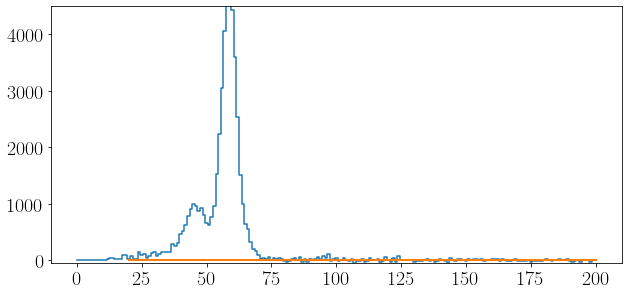

In [71]:
plt.figure(figsize=(cm2inch(26.0),cm2inch(12.0)))
plt.plot(x[bajo:alto],yresta[bajo:alto],drawstyle='steps-mid');
plt.ylim(-50,4500)
plt.plot([20,200],[0,0],lw=2);

Espectro anterior: zoom en la zona de número de cuentas bajo para mostrar que la resta produce un espectro con "cuentas negativas" en algunos canales. Esto es normal. En regiones con energías diferentes a las de los dos picos del $^{57}$Co cada espectro registra conteos del fondo. Los contenidos en cada canal en esta región son estadísticamente los mismios, con fluctuacionees. Estas fluctuaciones hacen que en algunos canales sus cuentas sean mayoritarias en un espectro.

Hagamos un zoom en la región de los picos. La literatura dice que sus energías son 122 y 137 keV.

In [72]:
x3 = x[30:80]
y3 = yresta[30:80]

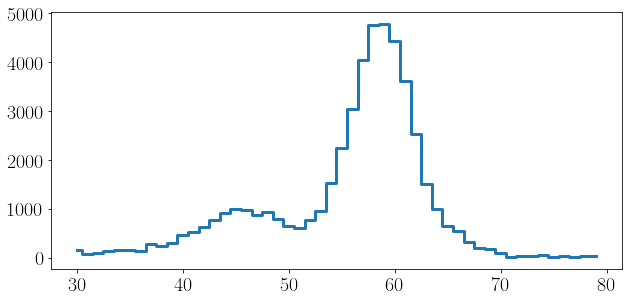

In [73]:
plt.figure(figsize=(cm2inch(26.0),cm2inch(12.0)))
plt.plot(x3,y3,drawstyle='steps-mid',lw=3);

Estimación de los parámetros de ajuste con dos gaussianas superpuestas a un fondo (método 'tandem' definido más arriba)

In [74]:
m1=46;m2=58;s1=4;s2=4; M1=1000; M2=5000;b0=1;b2=0 

In [75]:
yf = tandem(x3,m1,s1,M1,m2,s2,M2,b0,b1) # espectro estimado, graficado más abajo

La incertidumbre en el valor de cada canal es
$
I = I_1 - I_2 \\
\Delta I^ 2 = \left(\Delta I_1\right)^2 + \left(\Delta I_2\right)^2 \\
\Delta I_1 = \sqrt{I_1} \\
\Delta I = \sqrt{|I_1| + |I_2|}
$

In [76]:
ncrt = np.sqrt(np.abs(y1[30:80]) + np.abs(y2[30:80]))

Grafiquemos la incertidumbre...

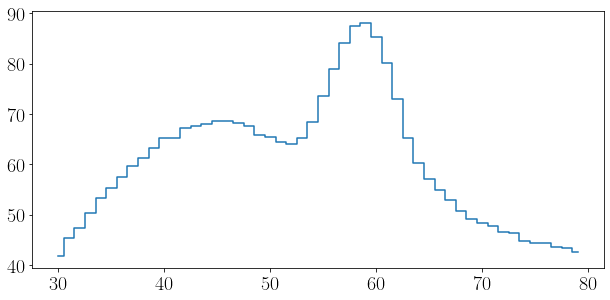

In [77]:
plt.figure(figsize=(cm2inch(26.0),cm2inch(12.0)))
plt.plot(x3,ncrt,ds='steps-mid');

Ahora sí grafiquemos la estimación...

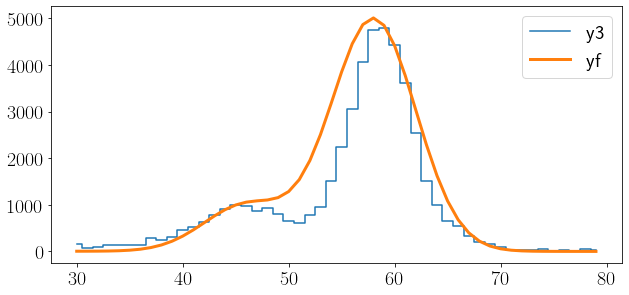

In [78]:
plt.figure(figsize=(cm2inch(26.0),cm2inch(12.0)))
plt.plot(x3,y3,ds='steps-mid',label='y3')
plt.plot(x3,yf,lw=3,label='yf')
plt.legend();

... parecen que los valores de la estimación son buenos. Ajustemos

In [79]:
p0 = np.array([m1, s1, M1, m2, s2, M2, b0, b1])
ncrt = np.sqrt(np.abs(y1[30:80]) + np.abs(y2[30:80]))
popt, pcov = curve_fit(tandem,x3,y3,p0)

In [80]:
m1, s1, M1, m2, s2, M2, b0, b1 = popt
y_fit = tandem(x3,m1, s1, M1, m2, s2, M2, b0, b1)

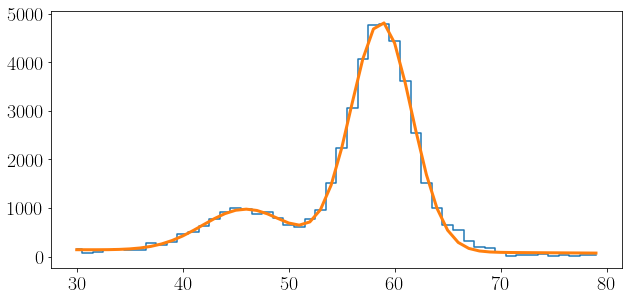

In [81]:
plt.figure(figsize=(cm2inch(26.0),cm2inch(12.0)))
plt.plot(x3,y3,ds='steps-mid')
plt.plot(x3,y_fit,lw=3);

Ahora no podemos usar statsGauss_tabla(). Pero usted puede modificarla para obtener los parámetros y sus incertidumbres para éste último caso de dos picos.

# Comparación NaI - Ge ; Borde Compton 

In [82]:
s1=np.genfromtxt('../in-out/NaI_60Co_600s.xy')
y1 = s1[:,1]
#a0 = -39.3
a0 = -20
a1 = 3.12
channels = 1024.
x1 = np.arange(0., channels, 1.)*a1 + a0



b0 = -26.5
b1= 0.36271
scl=1
s2 = np.genfromtxt('../in-out/calibracionNaCoCoCs-Ge8K.xy')
y2 = s2[:,1]/scl
x2 = s2[:,0]*b1 + b0


$
E_\gamma\text{(keV)} = a_0 + a_1 * canal
$

(0.0, 40000.0)

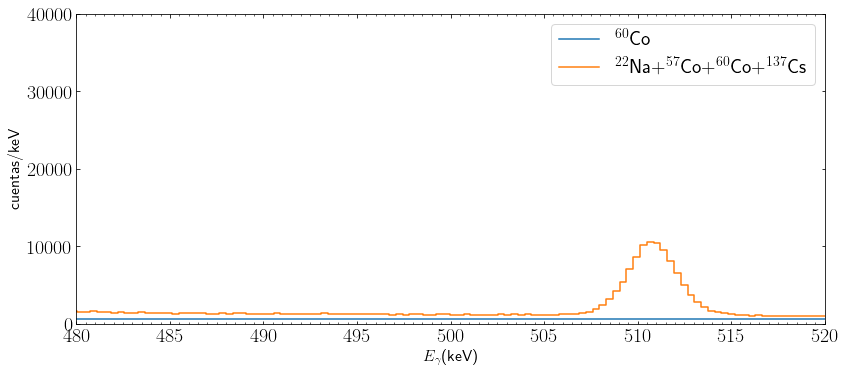

In [83]:
from matplotlib.ticker import AutoMinorLocator
fig = plt.figure(figsize=(cm2inch(30.0),cm2inch(15.0)))
grid = plt.GridSpec(1, 1, wspace=0.25, hspace=0.2,
                    left=0.1,right=0.98,bottom=0.17,top=0.9)

ax = fig.add_subplot(grid[0,0])
ax.tick_params(bottom=True,top=True,right=True,direction='in',which='both')

ax.plot(x1,y1,ds='steps-mid',label='$^{60}$Co')
ax.plot(x2,y2,ds='steps-mid',label='$^{22}$Na+$^{57}$Co+$^{60}$Co+$^{137}$Cs')
ax.legend(fontsize=20)
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.set_xlabel(r'$E_\gamma$(keV)',fontsize=16)
ax.set_ylabel('cuentas/keV',fontsize=16)
ax.set_xlim(480,520)
ax.set_ylim(0,40000)

Text(0.5, 0, '$E_\\gamma$(keV)')

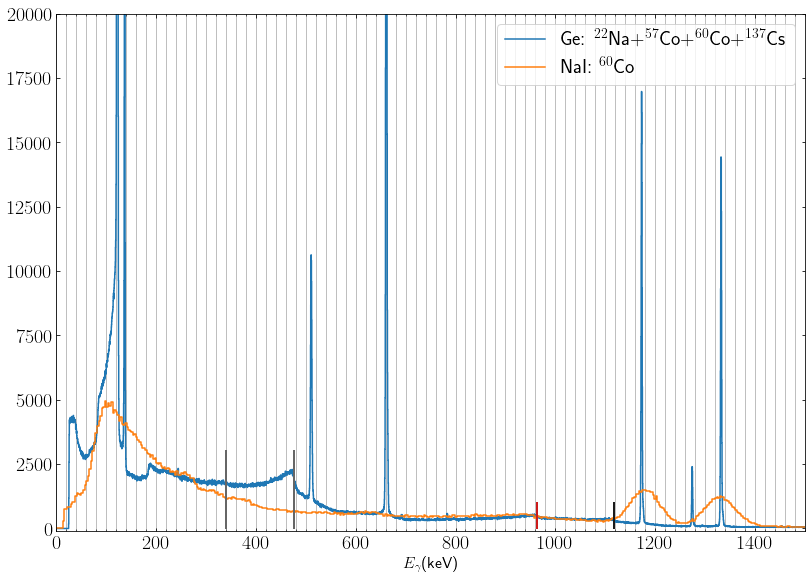

In [84]:
fig = plt.figure(figsize=(cm2inch(30.0),cm2inch(25.0)))
grid = plt.GridSpec(1, 1, wspace=0.25, hspace=0.2,
                    left=0.1,right=0.98,bottom=0.17,top=0.9)

ax = fig.add_subplot(grid[0,0])
ax.tick_params(bottom=True,top=True,right=True,direction='in',which='both')


ax.plot(x2,y2,ds='steps-mid',label='Ge: $^{22}$Na+$^{57}$Co+$^{60}$Co+$^{137}$Cs')
ax.plot(x1,y1,ds='steps-mid',label='NaI: $^{60}$Co')
ax.plot([1118,1118],[0,1000],c=(0.1,0.1,0.1),lw=2)
ax.plot([963,963],[0,1000],color=(0.8,0.1,0.1),lw=2)
ax.plot([477,477],[0,3000],color=(0.4,0.4,0.4),lw=2)
ax.plot([340,340],[0,3000],color=(0.4,0.4,0.4),lw=2)
ax.legend(fontsize=20)
ax.set_xlim(0,1500)
ax.set_ylim(-100,20000)
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.grid(which='both',axis='x')
ax.set_xlabel('$E_\gamma$(keV)',fontsize=16)

## Borde  Compton 

$
\epsilon =E_1\text{(keV)}/511 \\
E_2 = E_1/[1 + \epsilon (1-\cos\theta)]\\
\text{BC} = E_1 - E_2
$

In [85]:
E1 = 511
BC = E1*(1 - 1/(1 + E1/511 * (1-np.cos(np.pi)))) 
BC

340.6666666666667

# Calibración de detectores

El espectro que vamos a calibrar fue tomado poniendo en frente de un detector de Ge 4 fuentes: $^{22}$Na, $^{57}$Co, $^{60}$Co, $^{137}$Cs

In [86]:
# Leemos el espectro 
# x = canales
# y = cuentas

s = np.genfromtxt('../in-out/calibracionNaCoCoCs-Ge8K.xy')
x= s[:,0]
y= s[:,1]

(0.0, 4000.0)

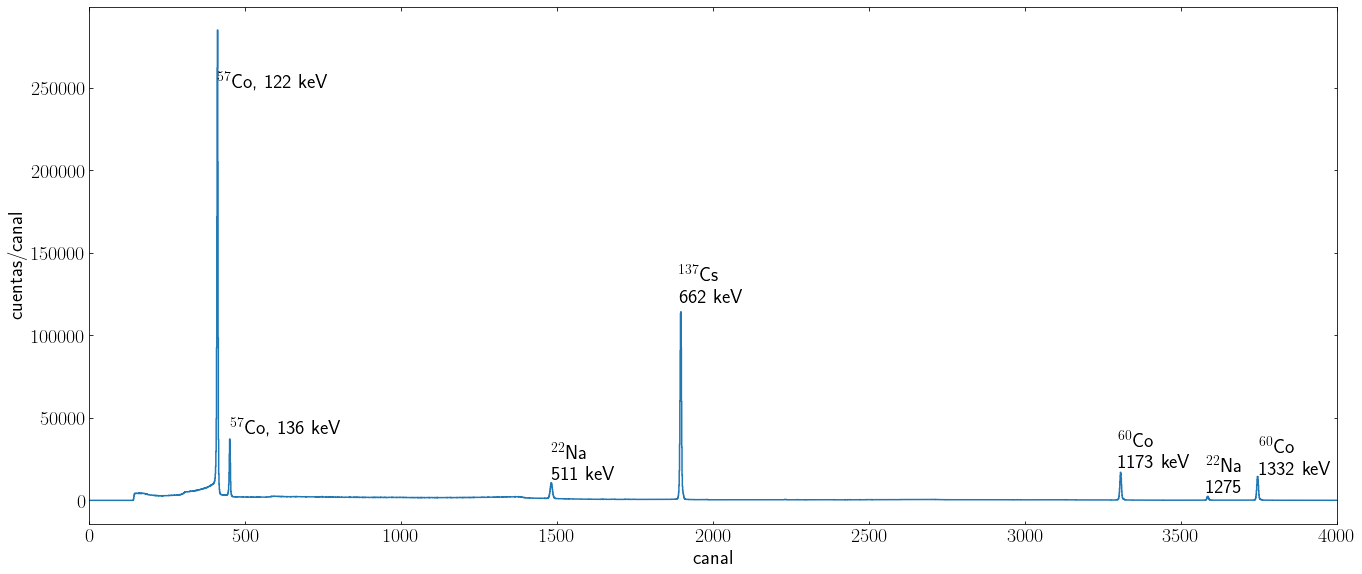

In [87]:
fig = plt.figure(figsize=(cm2inch(50.0),cm2inch(25.0)))
grid = plt.GridSpec(1, 1, wspace=0.25, hspace=0.2,
                    left=0.1,right=0.98,bottom=0.17,top=0.9)

ax = fig.add_subplot(grid[0,0])
ax.tick_params(bottom=True,top=True,right=True,direction='in',which='both')

ax.plot(x,y,ds='steps-mid',label='Ge: $^{22}$Na+$^{57}$Co+$^{60}$Co+$^{137}$Cs')

ax.annotate('$^{57}$Co, 122 keV',(410,250000))
ax.annotate('$^{57}$Co, 136 keV',(450,40000) )
ax.annotate('$^{22}$Na\n 511 keV',(1480,13000) )
ax.annotate('$^{137}$Cs\n 662 keV',(1890,120000) )
ax.annotate('$^{60}$Co\n 1173 keV',(3300,20000) )
ax.annotate('$^{60}$Co\n 1332 keV',(3750,16000) )
ax.annotate('$^{22}$Na\n 1275',(3580,5000) )

ax.xaxis.set_minor_locator(AutoMinorLocator(1))
ax.set_xlabel('canal')
ax.set_ylabel('cuentas/canal')
ax.set_xlim(0,4000)
#ax.set_xlim(1400,2000);
#ax.set_ylim(0,300000)
#ax.set_xlim(3000,4000);
#ax.set_ylim(0,50000);

Calibración: Lo que buscamos: la relación entre el número de canales y la energía en unidades del SI, típicamente en keV.

$
E_\gamma\,\text{(keV)} = a_0 + a_1 \times \text{canal}
$

es decir, debemos averigua el valor de $a_0$ y $a_1$. A manera de ejemplo, supongamos que solamente dispusiéramos de la fuente de $^{57}$Co.
Vamos a examinar "a ojo" la posición de cada pico.

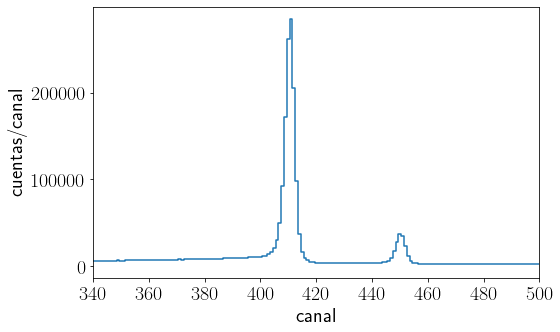

In [88]:
plt.subplots(figsize=(8,5))
plt.plot(x,y,ds='steps-mid')
plt.xlim(380,480)
plt.xticks(np.arange(340,501,20));
plt.xlabel('canal')
plt.ylabel('cuentas/canal');

De la gráfica podemos extraer las posiciones de los canales 410 y 450.
Vamos a guardar esas posicines en un arreglo 'canal' y E'

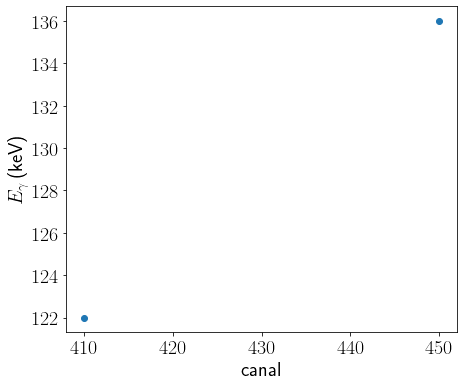

In [89]:
#canal = [410,450,1490,1895]
#E = [122,136,511,662]
canal = [410,450]
E = [122,136]

plt.subplots(figsize=(7, 6))
plt.scatter(canal,E)
plt.xlabel('canal')
plt.ylabel('$E_\gamma$\,(keV)');


En el caso de solamente dos puntos, encontrar $a_0$, $a_1$ es muy fácial

In [90]:
a1 = (136-122)/(450-410) # keV/canal
a1

0.35

In [91]:
#122 = a0 + a1 * 410  <- esta es la igualdad que deben cumplir a0 y a1 en el punto de más baja energía 
a0 = 122 - a1*410
print('a0 =',a0)
e = a0 + a1*450 # Verificaci'on de que la relación hallada devuelve la energía correcta en el canal 450 
e

a0 = -21.5


136.0

1. Definimos una función que calcule la energía dado el canal 'ca'
2. Por el método que ya usamos, "a ojo", determinamos las posiciones en canales de los picos de 511 keV y 662 keV.
3. Incluimos tales posiciones en el arreglo 'canal' y las correspondientes energías en 'E'
4. Hacemos una nueva gráfica incluyendo los cuatro puntos y trazamos la recta producida por a0 y a1 proveniente de considerar solamente dos puntos.

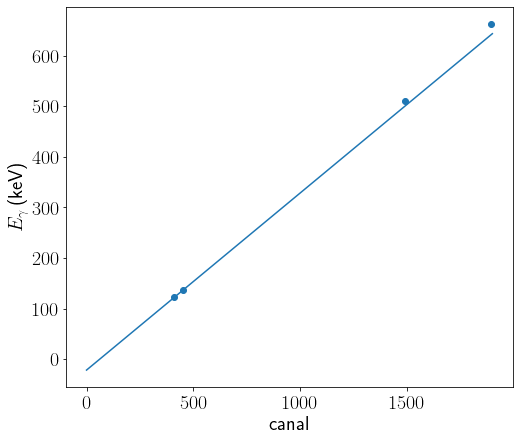

In [92]:
def Eg(ca,a0,a1):
    return a0 + a1 * ca

canal = [410,450,1490,1895]
E = [122,136,511,662]
#canal = [410,450]
#E = [122,136]

plt.subplots(figsize=(8, 7))
plt.scatter(canal,E)
plt.xlabel('canal')
plt.ylabel('$E_\gamma$\,(keV)')

xc = np.arange(0,1900)
yc = Eg(xc,a0,a1)   # recta producida por las constantes halladas con solamente los picos del Co-57
plt.plot(xc,yc);


Lo que observamos en la gráfica: la recta producida por a0, a1 no predice correctamente los puntos a las energías 511, 662 keV. 
Con cuatro puntos lo mejor para hacer es encontrar nuevos coeficientes que tengan en cuenta los cuatro puntos.

In [93]:
from scipy.optimize import curve_fit
p0 = np.array([a0,a1])
popt, pcov = curve_fit(Eg,canal,E,p0)
f0, f1 = popt
print('f0={0:2.2f} canales   f1={1:2.2f} keV/canal'.format(f0,f1))

f0=-27.36 canales   f1=0.36 keV/canal


Ahora vamos a comparar la recta producida por la pareja (a0,a1) con la recta producida por (f0,f1) 

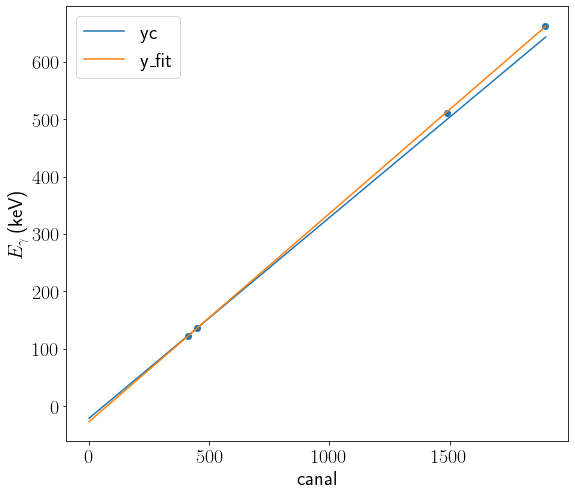

In [94]:
canal = [410,450,1490,1895]
E = [122,136,511,662]

plt.subplots(figsize=(9, 8))
plt.scatter(canal,E)
plt.xlabel('canal')
plt.ylabel(r'$E_\gamma$\,(keV)')
xc = np.arange(0,1900)
yc = Eg(xc,a0,a1)
plt.plot(xc,yc,label='yc');

y_fit = Eg(xc,f0,f1)
plt.plot(xc,y_fit,label='y\_fit')
plt.legend();


Primera aplicación de la calibración: vamos a usar la calibración para rotular el eje 'x' del espectro no en canales sino en keV

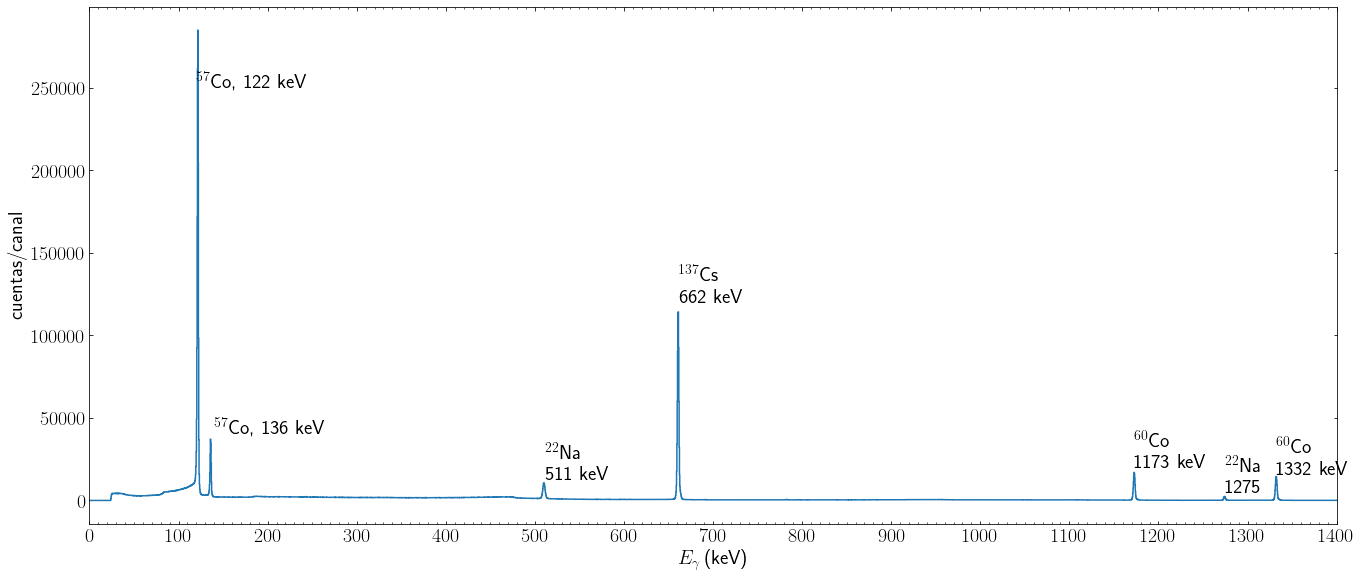

In [95]:
fig = plt.figure(figsize=(cm2inch(50.0),cm2inch(25.0)))
grid = plt.GridSpec(1, 1, wspace=0.25, hspace=0.2,
                    left=0.1,right=0.98,bottom=0.17,top=0.9)

ax = fig.add_subplot(grid[0,0])
ax.tick_params(bottom=True,top=True,right=True,direction='in',which='both')
ax.annotate('$^{57}$Co, 122 keV',(120,250000))
ax.annotate('$^{57}$Co, 136 keV',(140,40000) )
ax.annotate('$^{22}$Na\n 511 keV',(511,13000) )
ax.annotate('$^{137}$Cs\n 662 keV',(662,120000) )
ax.annotate('$^{60}$Co\n 1173 keV',(1173,20000) )
ax.annotate('$^{60}$Co\n 1332 keV',(1332,16000) )
ax.annotate('$^{22}$Na\n 1275',(1275,5000) )

xkeV = f0 + f1*x # <------ conversión de canales a keVs
ax.plot(xkeV,y,ds='steps-mid',label='Ge: $^{22}$Na+$^{57}$Co+$^{60}$Co+$^{137}$Cs')

ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.set_xlim(0,1400);
ax.set_xlabel(r'$E_\gamma$\,(keV)')
ax.set_ylabel('cuentas/canal')
ax.set_xticks(np.arange(0,1401,100));

Una calibración 'técnica', o 'científica', no la hecemos "a ojo", sino que determinamos el centroide de cada pico ajustándolo a una gaussiana.

Pero el resultado es el mismo: una relación lineal entre los canales y la energía.